1. feladat: Készítsen programot, mely egy fényképezogép raw képei alapján megvilágítás-mérést ˝
végez.
A program tehát egy képet kap bemenetén és kiad egy számot arról, átlagosan hány lux megvilágítás érte az objektívet a kép alkotásakor. Ehhez az alábbiakat használhatja fel:

- a raw kép pixel-adatai: rawpy modul
- a kép EXIF adatai közül az ISO-érzékenység, az apertúra-méret (F-szám) és az expozíciós ido˝
(T): pyexiv2 modul (errol talál anyagot a Moodle-lapon) ˝

Kalibráláshoz felhasználhat mobil-telefon megvilágítás-méro alkalmazását. (Ez persze nem hi- ˝
teles értéket ad, de ha ezzel megy az eljárás, akkor a feladatot megoldotta és a mindennapokban jó
közelítést ad a módszer.)
A megoldáshoz szükséges, hogy 8–10 teszt esetben készítsen fénykép-luxmérés párokat és keressen olyan súlyfaktorokat a szenzor R, G és B komponenseihez, melyekkel azokat felszorozva és
összegezve, majd leosztva az (ISO · T)/F2 mennyiséggel, megkapja a lux-értéket.
(Az (ISO · T)/F2 mennyiséggel azért kell leosztani, hogy kompenzáljuk az eltéro objektív- ˝
fényero, ISO érzékenység és expozíciós id ˝ o hatását.) ˝
Ismertessen röviden egy potenciális alkalmazást ehhez a programhoz!

In [1]:
!pip install rawpy
!pip install pyexiv2
!pip install numpy
!pip install matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import rawpy
import pyexiv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.ndimage import gaussian_filter

/home/matyko/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
lux_values = [52.9,226,1430,1920,44.3,102,1800,94.5,179] # measured lux values, from Photone app, using Samsung Galaxy A52 front facing camera and a small paper as a diffuser

In [4]:
def display_image(image_path, text):
    raw = rawpy.imread(image_path)
    rgb = raw.postprocess()
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.text(10, 10, text, color='white', fontsize=12, backgroundcolor='black')
    plt.show()

In [5]:
def display_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.raw', '.nef', '.cr2', '.arw', '.dng')):  # Add other raw file extensions as needed
            image_path = os.path.join(folder_path, filename)
            image_sequence = int(filename.split('.')[0])
            print(image_sequence)
            text = f"Lux: {lux_values[image_sequence-1]}"
            display_image(image_path, text)

#### A kiválsztott képek RAW formátumban és minden képhez a mért LUX érték

A LUX érték mérését a Photone alkalmazással (https://growlightmeter.com/) végeztem. Összesen 9 mérést végeztem amiből kettő kültéren Napos megvilágításnál 7 mérést pedog beltéren. A Beltéri mérések során extra megvilágitást nem használtam, csak a külső napfény adott megvilágítást. 

- A beltéri mérések közül 2 mérés ugyan azon a helyszinen készült egyetlen különmbség, hogy az adott helyszínen a fényroló dölésszögét állítottam, hogy egyszer a lehető legtöbb fényt, másszor pedig lehetőleg minnél kevesebb fényt engedjen be. Emellet még 3 mérést végeztem beltérben ahol több ablakon keresztül is érekezett fény az adott szobába, illetve végeztem egy mérést egy lécspő feljároban ahol egy tetőablak adott csak megvilágítást.

8


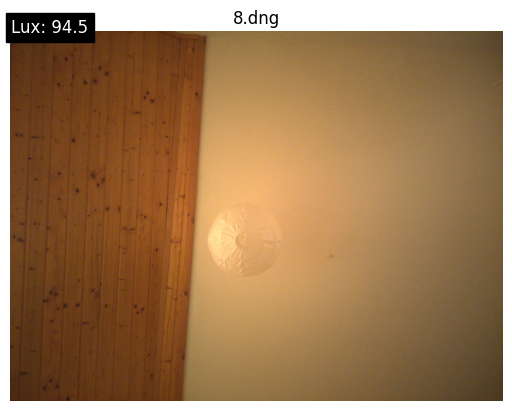

9


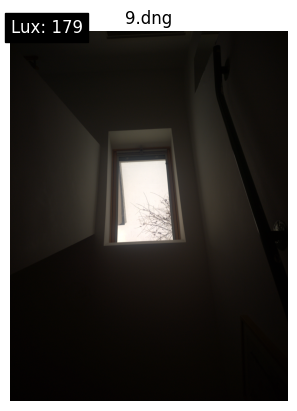

6


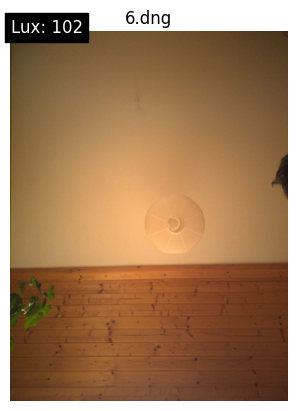

1


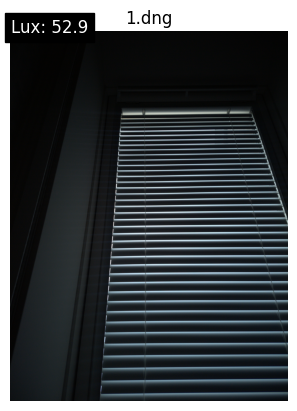

2


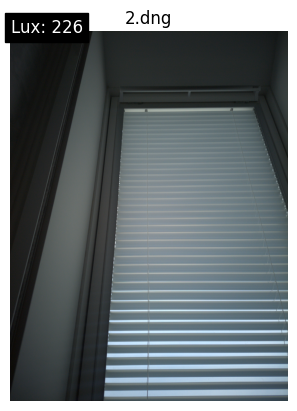

4


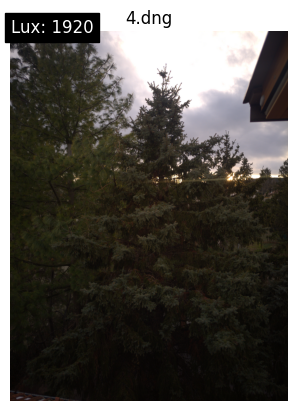

5


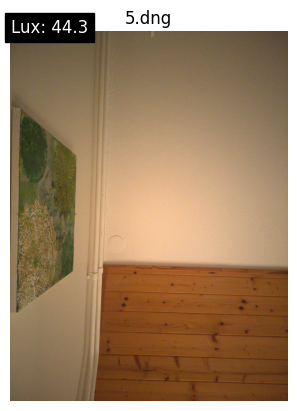

3


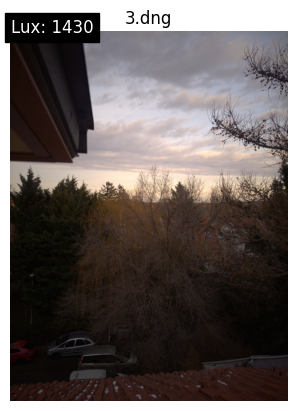

7


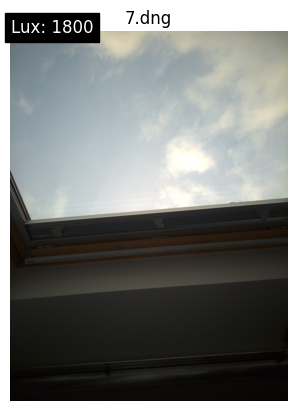

In [6]:
folder_path = 'Imgs'
display_images_in_folder(folder_path)

In [7]:
def get_exif_data(image_path):
    img = pyexiv2.Image(image_path)
    exif_data = img.read_exif_detail()
    
    exposure_time = exif_data['Exif.Image.ExposureTime']
    focal_length = exif_data['Exif.Image.FocalLength']
    iso_data = exif_data['Exif.Image.ISOSpeedRatings']
    
    return exposure_time, focal_length, iso_data

In [8]:
#read in all the images in the folder and store them in a list
raw_images = []
exif_data = []
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.raw', '.nef', '.cr2', '.arw', '.dng')):  # Add other raw file extensions as needed
        image_path = os.path.join(folder_path, filename)
        raw_images.append(rawpy.imread(image_path))

        iso, aperture, exposure_time = get_exif_data(image_path)
        exif_data.append((iso, aperture, exposure_time))

In [9]:
def display_image_raw(image, text):
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.text(10, 10, text, color='white', fontsize=12, backgroundcolor='black')
    plt.show()

In [10]:
# R G B súly faktorok beállítása
R_factor = 0.21
G_factor = 0.08
B_factor = 0.12

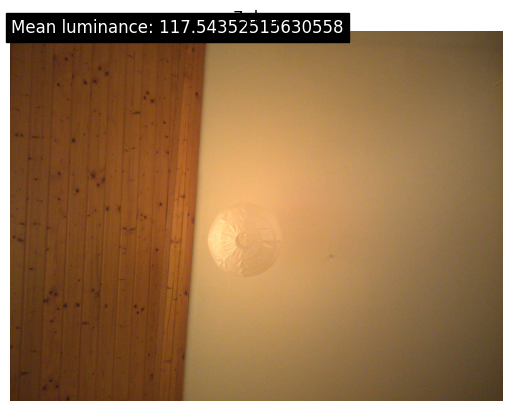

Mean luminance: 117.54352515630558


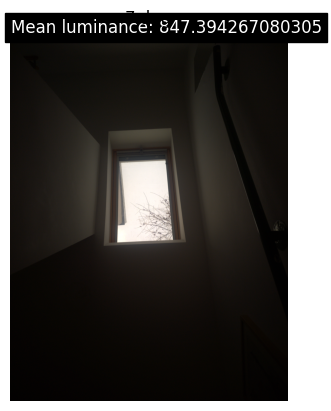

Mean luminance: 847.394267080305


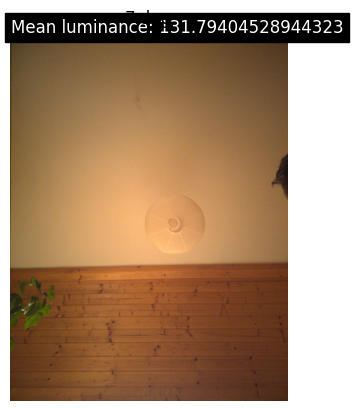

Mean luminance: 131.79404528944323


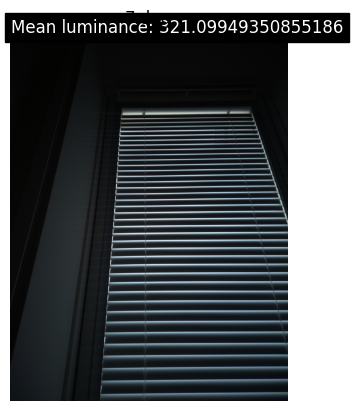

Mean luminance: 321.09949350855186


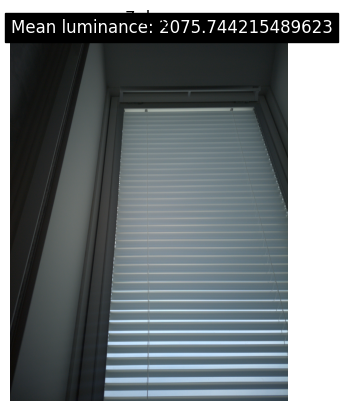

Mean luminance: 2075.744215489623


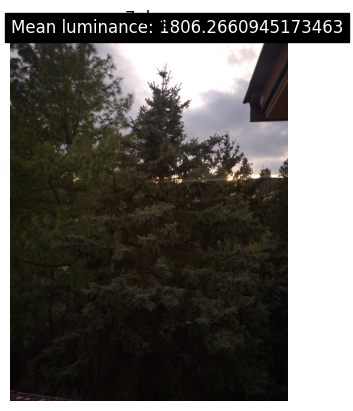

Mean luminance: 1806.2660945173463


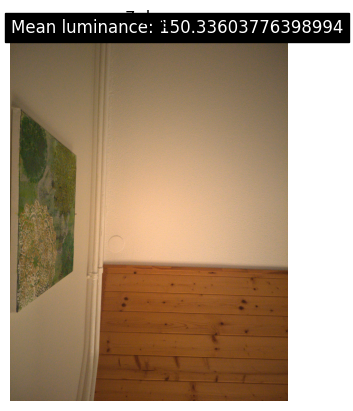

Mean luminance: 150.33603776398994


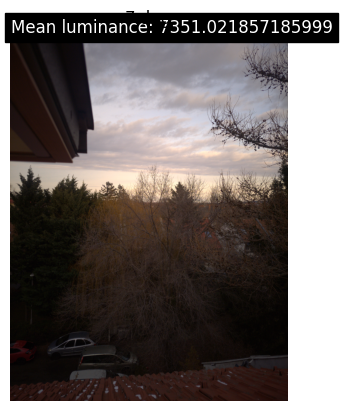

Mean luminance: 7351.021857185999


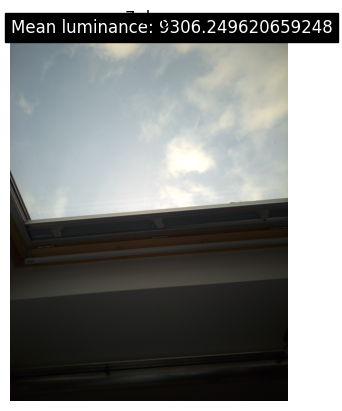

Mean luminance: 9306.249620659248


In [11]:
lux_guessed = []

for img,exif in zip(raw_images,exif_data):
    rgb = img.postprocess()

    luminance = R_factor * rgb[:, :, 0] + G_factor * rgb[:, :, 1] + B_factor * rgb[:, :, 2]

    exp_time = int(exif[0]['value'].split('.')[0].split('/')[0]) / int(exif[0]['value'].split('.')[0].split('/')[1])
    focal_length = int(exif[1]['value'].split('.')[0].split('/')[0]) / int(exif[1]['value'].split('.')[0].split('/')[1])
    iso = int(exif[2]['value'])

    optics_scale_value = (iso * exp_time) / (focal_length ** 2)

    luminance = luminance / optics_scale_value

    lux_guessed.append(np.mean(luminance))

    display_image_raw(rgb, f"Mean luminance: {np.mean(luminance)}")

    print(f"Mean luminance: {np.mean(luminance)}")

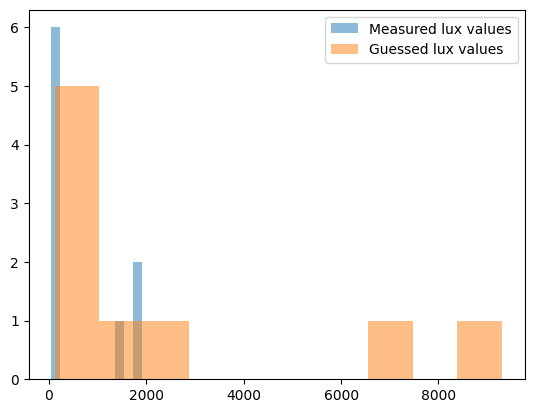

In [17]:
# plot the measured lux values and the guessed lux values, with a histogram
plt.figure()
plt.hist(lux_values, bins=10, alpha=0.5, label='Measured lux values')
plt.hist(lux_guessed, bins=10, alpha=0.5, label='Guessed lux values')
plt.legend(loc='upper right')

A RAW képekből becsült LUX értékekekben található eltérés az eredeti méréskhez képest, amely részben be tudható az adott méréspárok közötti külömbségnek, RAW kép készitésére a telefon hátsó kamerája volt használható, ezzel szemben a Photone alkalmazás a telefon első (szelfi) kameráját használta. Ezen felül a feldolgozásból is adodik külömbség. A beszült értékek szokszor megközelítik a az ereditleg még értéket de szélsőséges fényviszonyokban nagy eltérés tapasztalható. 

### Lehetséges alkalmazási terület

Autóknak az autómata fényszóró kezelését, lehetne ennek a progrmnak az alapjával irányitani, amennyiben egy megadott LUX érték alá kerül a mért fény mennyisége, abban az esetben kapcsolja a távolsági fényszórót, vagy illetve még kevesebb fény esetén akár a reflektort. 